In [12]:
#importing the required python libraries
import numpy as np
import matplotlib.pyplot as plt

from urllib.request import urlretrieve
from os.path import isfile, isdir, getsize
from os import mkdir, makedirs, remove, listdir
from tqdm import tqdm

import zipfile
import tarfile
import pickle

from keras.models import Sequential, Model
from keras import optimizers
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator

import glob
import shutil

import pickle

In [13]:
catdog_dataset_folder_path = 'catdog'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('catdog.zip'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Doge n Cate Dataset') as pbar:
        urlretrieve(
            'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip',
            'catdog.zip',
            pbar.hook)

if not isdir(catdog_dataset_folder_path):
    mkdir(catdog_dataset_folder_path)
    with zipfile.ZipFile('catdog.zip') as f:
        f.extractall('./'+catdog_dataset_folder_path)
        # Unfortunately some of the files are corrupt so we need to clean these out:
        !apt-get install -y jhead > /dev/null 2>&1
        !jhead -de catdog/PetImages/Cat/*.jpg > /dev/null 2>&1 
        !jhead -de catdog/PetImages/Dog/*.jpg > /dev/null 2>&1

# Download numpy files which will be used in transfer learning section
if not isfile('bottleneck_features_train.npy'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Bottleneck features') as pbar:
        urlretrieve(
                'https://www.dropbox.com/s/a38gpvdcryw0kfc/bottleneck.zip?dl=1',
                'bottleneck.zip',
                pbar.hook)

    with zipfile.ZipFile('bottleneck.zip') as f:
        f.extractall('./')
        
    files = listdir('bottleneck 2/')
    
    for f in files:
        shutil.move('bottleneck 2/'+f,'./')
    shutil.rmtree('bottleneck 2/')
    remove('bottleneck.zip')

Doge n Cate Dataset: 825MB [04:06, 3.35MB/s]                                                                           
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
Bottleneck features: 166MB [00:54, 3.05MB/s]                                                                           


In [15]:
files = glob.glob(catdog_dataset_folder_path+'/PetImages/**/*.jpg')
labels = np.array([0]*12500+[1]*12500)

size = np.zeros(len(files))
for i,f in enumerate(files):
    size[i] = getsize(f)
    
idx = np.where(size==0)[0]
for i in idx[::-1]:
    del files[i]
    labels = np.delete(labels, i)

In [16]:
np.random.permutation(5)

array([4, 3, 2, 1, 0])

In [17]:
len_data = len(files)
train_examples = 20000
test_examples = len_data - train_examples

# randomly choose 20000 as training and testing cases
permutation = np.random.permutation(len_data)
train_set = [files[i] for i in permutation[:train_examples]]
test_set = [files[i] for i in permutation[-test_examples:]]
train_labels = labels[permutation[:train_examples]]
test_labels = labels[permutation[-test_examples:]]

train_folder = catdog_dataset_folder_path+'/train'
test_folder = catdog_dataset_folder_path+'/test'

if isdir(train_folder): #if directory already exists
    shutil.rmtree(train_folder)    
if isdir(test_folder): #if directory already exists
    shutil.rmtree(test_folder)    
makedirs(train_folder+'/cat/')
makedirs(train_folder+'/dog/')
makedirs(test_folder+'/cat/')
makedirs(test_folder+'/dog/')

for f,i in zip(train_set, train_labels):
    if i==0:
        shutil.copy2(f, train_folder+'/cat/')
    else:
        shutil.copy2(f, train_folder+'/dog/')
        
for f,i in zip(test_set, test_labels):
    if i==0:
        shutil.copy2(f, test_folder+'/cat/')
    else:
        shutil.copy2(f, test_folder+'/dog/')

Found 20000 images belonging to 2 classes.


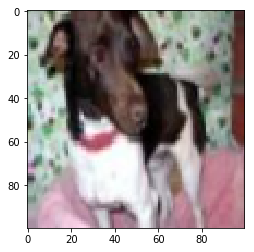

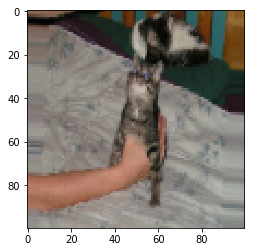

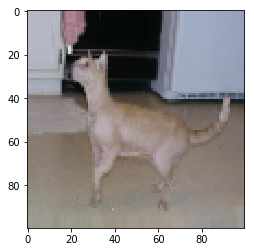

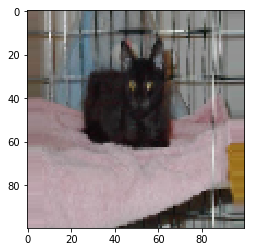

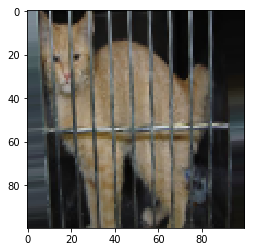

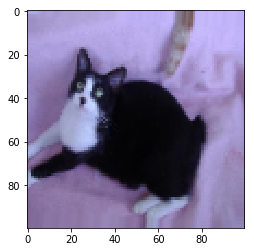

In [18]:
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=5,
        zoom_range=0.2,
        horizontal_flip=True)

img_height = img_width = 100
channels = 3
train_generator = datagen.flow_from_directory(
    train_folder,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode=None)

i = 0
img_list = []
for batch in train_generator: #.flow(x, batch_size=1)
    img_list.append(batch)
    i += 1
    if i > 5:
        break
        

for img in img_list:
    plt.imshow(np.squeeze(img))
    plt.show()

In [20]:
from keras import applications

datagen = ImageDataGenerator(rescale=1.0/255)
model = applications.VGG16(include_top=False, input_shape=(img_width, img_height, channels))

In [21]:
model = applications.VGG16(include_top=False, weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [22]:
with open('bottleneck_features_train.npy','rb') as f:
    bottleneck_features_train = pickle.load(f)

In [23]:
bottleneck_features_train.shape

(19872, 3, 3, 512)

In [24]:
batch_size = 128
generator = datagen.flow_from_directory(
    train_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

Found 20000 images belonging to 2 classes.


In [25]:
batch_size = 128
valid_generator = datagen.flow_from_directory(
    test_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

Found 4998 images belonging to 2 classes.


In [26]:
with open('bottleneck_features_train.npy','rb') as f:
    bottleneck_features_train = pickle.load(f)

model = Sequential()
model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 1,180,161
Trainable params: 1,180,161
Non-trainable params: 0
_________________________________________________________________


In [27]:
batch_size = 128
generator = datagen.flow_from_directory(
    train_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

labels = np.array([0 if f.startswith('cat') else 1 for f in generator.filenames])[:len(bottleneck_features_train)]
model.fit(bottleneck_features_train, labels, epochs=15, batch_size=batch_size)

Found 20000 images belonging to 2 classes.
Epoch 1/15
19872/19872 [==============================] - ETA: 1:57 - loss: 1.0067 - acc: 0.406 - ETA: 42s - loss: 3.2123 - acc: 0.510 - ETA: 26s - loss: 2.5140 - acc: 0.55 - ETA: 20s - loss: 1.9849 - acc: 0.58 - ETA: 16s - loss: 1.7074 - acc: 0.58 - ETA: 14s - loss: 1.5981 - acc: 0.57 - ETA: 12s - loss: 1.4345 - acc: 0.59 - ETA: 11s - loss: 1.3068 - acc: 0.62 - ETA: 10s - loss: 1.2130 - acc: 0.63 - ETA: 9s - loss: 1.1379 - acc: 0.6476 - ETA: 9s - loss: 1.0702 - acc: 0.661 - ETA: 8s - loss: 1.0135 - acc: 0.675 - ETA: 8s - loss: 0.9673 - acc: 0.685 - ETA: 7s - loss: 0.9319 - acc: 0.691 - ETA: 7s - loss: 0.9200 - acc: 0.685 - ETA: 7s - loss: 0.8906 - acc: 0.690 - ETA: 6s - loss: 0.8637 - acc: 0.696 - ETA: 6s - loss: 0.8361 - acc: 0.704 - ETA: 6s - loss: 0.8171 - acc: 0.709 - ETA: 6s - loss: 0.8075 - acc: 0.706 - ETA: 5s - loss: 0.7879 - acc: 0.713 - ETA: 5s - loss: 0.7702 - acc: 0.718 - ETA: 5s - loss: 0.7529 - acc: 0.724 - ETA: 5s - loss: 0.735

19872/19872 [==============================] - ETA: 4s - loss: 0.2646 - acc: 0.859 - ETA: 4s - loss: 0.2745 - acc: 0.864 - ETA: 4s - loss: 0.2872 - acc: 0.857 - ETA: 4s - loss: 0.2839 - acc: 0.868 - ETA: 4s - loss: 0.2847 - acc: 0.873 - ETA: 4s - loss: 0.3026 - acc: 0.862 - ETA: 4s - loss: 0.3140 - acc: 0.863 - ETA: 4s - loss: 0.3060 - acc: 0.867 - ETA: 4s - loss: 0.3037 - acc: 0.867 - ETA: 4s - loss: 0.3010 - acc: 0.868 - ETA: 4s - loss: 0.2990 - acc: 0.871 - ETA: 4s - loss: 0.3046 - acc: 0.866 - ETA: 4s - loss: 0.3041 - acc: 0.866 - ETA: 4s - loss: 0.3032 - acc: 0.867 - ETA: 4s - loss: 0.3047 - acc: 0.866 - ETA: 4s - loss: 0.3090 - acc: 0.863 - ETA: 3s - loss: 0.3032 - acc: 0.866 - ETA: 3s - loss: 0.2992 - acc: 0.869 - ETA: 3s - loss: 0.2986 - acc: 0.870 - ETA: 3s - loss: 0.3000 - acc: 0.869 - ETA: 3s - loss: 0.3013 - acc: 0.869 - ETA: 3s - loss: 0.3037 - acc: 0.869 - ETA: 3s - loss: 0.3026 - acc: 0.869 - ETA: 3s - loss: 0.3002 - acc: 0.870 - ETA: 3s - loss: 0.2989 - acc: 0.871 - ETA

19872/19872 [==============================] - ETA: 4s - loss: 0.2339 - acc: 0.867 - ETA: 4s - loss: 0.2550 - acc: 0.875 - ETA: 4s - loss: 0.2546 - acc: 0.884 - ETA: 4s - loss: 0.2558 - acc: 0.878 - ETA: 4s - loss: 0.2557 - acc: 0.881 - ETA: 4s - loss: 0.2536 - acc: 0.884 - ETA: 4s - loss: 0.2570 - acc: 0.885 - ETA: 4s - loss: 0.2552 - acc: 0.886 - ETA: 4s - loss: 0.2536 - acc: 0.886 - ETA: 4s - loss: 0.2544 - acc: 0.885 - ETA: 4s - loss: 0.2606 - acc: 0.882 - ETA: 4s - loss: 0.2579 - acc: 0.883 - ETA: 4s - loss: 0.2592 - acc: 0.883 - ETA: 4s - loss: 0.2607 - acc: 0.884 - ETA: 4s - loss: 0.2582 - acc: 0.887 - ETA: 4s - loss: 0.2564 - acc: 0.887 - ETA: 4s - loss: 0.2580 - acc: 0.886 - ETA: 3s - loss: 0.2637 - acc: 0.884 - ETA: 3s - loss: 0.2649 - acc: 0.884 - ETA: 3s - loss: 0.2677 - acc: 0.884 - ETA: 3s - loss: 0.2660 - acc: 0.886 - ETA: 3s - loss: 0.2650 - acc: 0.887 - ETA: 3s - loss: 0.2626 - acc: 0.889 - ETA: 3s - loss: 0.2617 - acc: 0.890 - ETA: 3s - loss: 0.2636 - acc: 0.889 - ETA

19872/19872 [==============================] - ETA: 4s - loss: 0.2392 - acc: 0.906 - ETA: 4s - loss: 0.2382 - acc: 0.898 - ETA: 4s - loss: 0.2344 - acc: 0.904 - ETA: 4s - loss: 0.2311 - acc: 0.907 - ETA: 4s - loss: 0.2229 - acc: 0.908 - ETA: 4s - loss: 0.2178 - acc: 0.909 - ETA: 4s - loss: 0.2152 - acc: 0.909 - ETA: 4s - loss: 0.2201 - acc: 0.907 - ETA: 4s - loss: 0.2279 - acc: 0.904 - ETA: 4s - loss: 0.2272 - acc: 0.903 - ETA: 4s - loss: 0.2178 - acc: 0.908 - ETA: 4s - loss: 0.2141 - acc: 0.909 - ETA: 4s - loss: 0.2182 - acc: 0.909 - ETA: 4s - loss: 0.2204 - acc: 0.907 - ETA: 4s - loss: 0.2215 - acc: 0.906 - ETA: 4s - loss: 0.2228 - acc: 0.905 - ETA: 4s - loss: 0.2198 - acc: 0.907 - ETA: 4s - loss: 0.2150 - acc: 0.908 - ETA: 3s - loss: 0.2156 - acc: 0.910 - ETA: 3s - loss: 0.2139 - acc: 0.911 - ETA: 3s - loss: 0.2154 - acc: 0.910 - ETA: 3s - loss: 0.2144 - acc: 0.911 - ETA: 3s - loss: 0.2153 - acc: 0.910 - ETA: 3s - loss: 0.2141 - acc: 0.910 - ETA: 3s - loss: 0.2131 - acc: 0.911 - ETA

In [28]:
with open('bottleneck_features_valid.npy','rb') as f:
    bottleneck_features_valid = pickle.load(f)
valid_labels = np.array([0 if f.startswith('cat') else 1 for f in valid_generator.filenames])[:len(bottleneck_features_valid)]
y_valid_pred = model.predict_classes(bottleneck_features_valid)
accuracy = np.count_nonzero(valid_labels == y_valid_pred.ravel())/len(valid_labels)

print('\nThe accuracy is: '+str(accuracy))


The accuracy is: 0.9285420944558521
